In [127]:
#Bibliotheken einbinden
import pandas as pd
from pathlib import Path
from numpy.polynomial.polynomial import polyfit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

In [70]:
sensoren_skizze = [
    "TL", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9",
    "T10", "T11", "T12", "T13", "T14", "T15", "T16", "T17", "T18", "T19"
]

# Excelbezeichnung
sensoren_excel = [
    "T11", "T6", "T9", "T4", "T15", "T14", "T10", "T17", "T12", "T13",
    "T3", "T19", "T7", "T8", "T18", "T20", "T16", "T1", "T2", "T5"
]

# Umwandeln in Dictionary
skizze_to_excel = dict(zip(sensoren_skizze, sensoren_excel))
excel_to_skizze = dict(zip(sensoren_excel, sensoren_skizze))

#Skizzenbezeichnung
#Sensoren im Teilquerschnitt
sensoren_links_skizze = ["TL", "T1", "T2", "T3", "T4", "T5", "T6", "T18", "T19"]
sensoren_rechts_skizze = ["TL", "T10", "T11", "T12", "T13", "T14", "T15", "T16", "T17"]

#Sensorhöhen nach Skizzenbezeichnung
sensor_hoehen = {
"TL": 0.25, #TL (Referenzpunkt)
"T1": 1.25, "T2": 0.75, "T3": 0.25, "T4": 0.25, "T5": 0.75, "T6": 1.25, #T1-6
"T7": 1.71, "T8": 1.81, "T9": 1.91, #T7-9
"T10": 1.25, "T11": 0.75, "T12": 0.25, "T13": 0.25, "T14": 0.75, "T15": 1.25, #T10-15
"T16": 1.5, "T17": 1.6, #T16-17
"T18": 1.5, "T19": 1.6, #T18-19
}

In [51]:
#Liefert Sensordaten in Skizzenreihenfolge
def hole_sensorwerte(df, sensoren_skizze):
    excel_spalten = [skizze_to_excel[s] for s in sensoren_skizze]
    return df[excel_spalten].values


In [52]:
datein = Path.cwd().glob("*.csv") #Dateipfad für csv-Dateien im selben Ordner wie Skript

cols = ["number", "date", "time"] + [f"T{i}" for i in range(1, 21)] #Kopfzeile erstellen, ersetzt die der csv-Datein

dfs = []

for i in datein:
    try:
        df = pd.read_csv(
            i,
            sep=";",
            encoding="latin1",
            skiprows=2,
            names=cols,
            usecols=range(23),
            on_bad_lines="skip"   # skippen von fehlerbehafteten Zellen
        )
        dfs.append(df)
    except pd.errors.EmptyDataError:
        continue

gesamt_df = pd.concat(dfs, ignore_index=True)

#COdeblock nötig zum bereinigen der dezimaltrenner. Beim Einlesen der CSV-Datein hat 'decimal=","' nicht zuverlässig funktioniert.
#Daher werden hier alle , durch . ersetzt und der String als Zahl abgespeichert

temp_spalten = gesamt_df.filter(like="T").columns #erstellen von einer Liste der Temperaturspalten


gesamt_df[temp_spalten] = ( #Ersetzen
    gesamt_df[temp_spalten]
    .astype(str)
    .replace(",", ".", regex = True)
    .apply(pd.to_numeric, errors="coerce")
)

#Codeblock zum erstellen eines Indexes für alle Zeilen aus spalten "Date" und "Time"

gesamt_df["datetime"] = pd.to_datetime(
    gesamt_df["date"] + " " + gesamt_df["time"],
    format="%d.%m.%Y %H:%M:%S"
)


gesamt_df = gesamt_df.set_index("datetime") #"datetime" als index setzen
gesamt_df = gesamt_df.sort_index() #Dataframe nach "datetime" sortieren

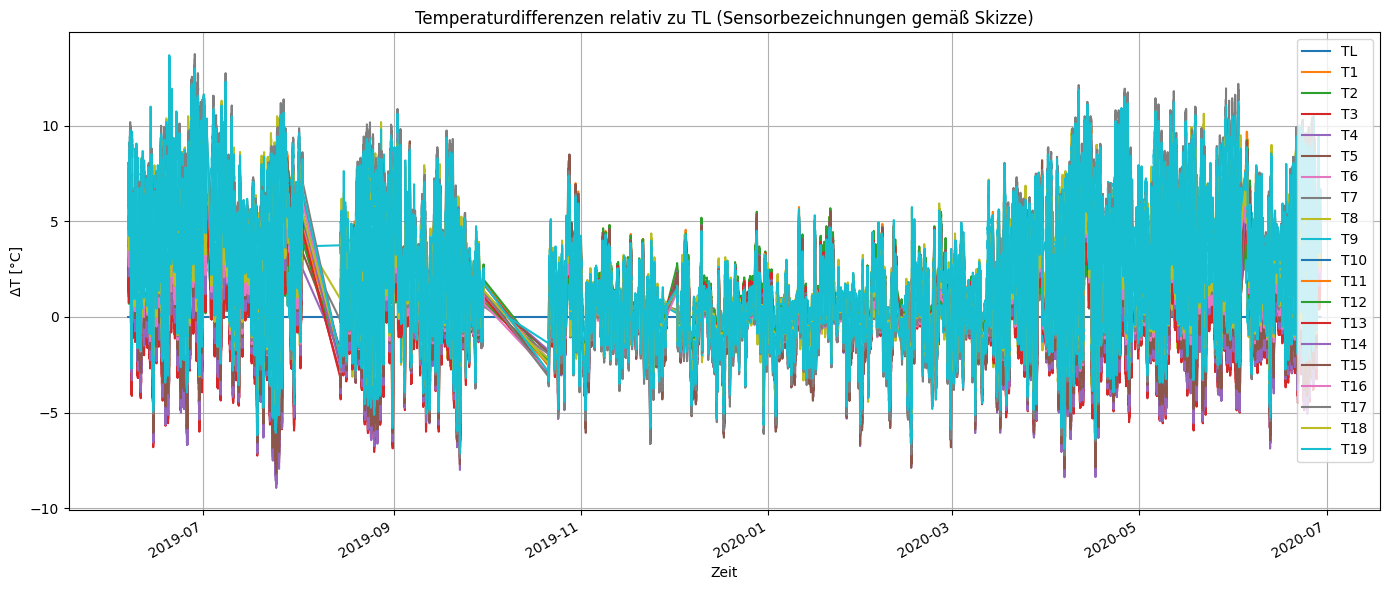

In [5]:
# Plot der Temperaturdifferenzen zu TL

# Sensordaten in Skizzenreihenfolge holen
werte_skizze = hole_sensorwerte(gesamt_df, sensoren_skizze)

# DataFrame mit Skizzenbezeichnungen erzeugen
df_skizze = pd.DataFrame(
    werte_skizze,
    index=gesamt_df.index,
    columns=sensoren_skizze
)

# Temperaturdifferenzen relativ zu TL
df_diff = df_skizze.sub(df_skizze["TL"], axis=0)

# Plot
df_diff.loc["2019-06-06":"2020-06-28"].plot(
    figsize=(14, 6),
    title="Temperaturdifferenzen relativ zu TL (Sensorbezeichnungen gemäß Skizze)",
)

plt.ylabel("ΔT [°C]")
plt.xlabel("Zeit")
plt.grid(True)
plt.tight_layout()
plt.show()


In [107]:
def plot_mitteltemperaturen(start, ende, querschnitt, title=None, min_abstand_x=0.3, offset_x=0.25):
    """
    Plottet mittlere Sensortemperaturen gegen Höhe für einen beliebigen Zeitraum.
    Labels werden nach rechts verschoben, falls Punkte auf gleicher Höhe zu nah sind.

    Parameter:
    - start, ende: Zeitraum als string, z.B. "2019-07-15" oder "2019-07-15 12:00"
    - querschnitt: "links", "rechts" oder "gesamt" (welche Sensoren angezeigt werden)
    - title: optional, Titel des Plots
    - min_abstand_x: minimale x-Distanz, bevor Label verschoben wird
    - offset_x: Verschiebung nach rechts für überlappende Labels
    """

    if querschnitt == "links":
        sensoren_skizze_plot = sensoren_links_skizze
    elif querschnitt == "rechts":
        sensoren_skizze_plot = sensoren_rechts_skizze
    elif querschnitt == "gesamt":
        sensoren_skizze_plot = sensoren_skizze
    else:
        raise ValueError("querschnitt muss 'links', 'rechts' oder 'gesamt' sein")

    # Zeitraum filtern
    df_zeitraum = gesamt_df.loc[start:ende]

    # Sensordaten in Skizzenreihenfolge holen
    werte = hole_sensorwerte(df_zeitraum, sensoren_skizze_plot)

    # DataFrame mit Skizzenbezeichnungen
    df_skizze = pd.DataFrame(werte, index=df_zeitraum.index, columns=sensoren_skizze_plot)

    # Mittlere Werte pro Sensor
    mittelwerte = df_skizze.mean()

    # Höhen in derselben Reihenfolge
    hoehen = np.array([sensor_hoehen[s] for s in sensoren_skizze_plot])

    # Sortieren nach Höhe
    idx = np.argsort(hoehen)
    hoehen = hoehen[idx]
    sensor_sortiert = np.array(sensoren_skizze_plot)[idx]
    x_werte = np.array([mittelwerte[s] for s in sensor_sortiert])

    # Scatterplot
    plt.figure(figsize=(6,8))
    plt.scatter(x_werte, hoehen, color='orange', s=50)

    # Sensoren nach Höhe gruppieren
    hoehe_to_sensoren = {}
    for s, h, x in zip(sensor_sortiert, hoehen, x_werte):
        hoehe_to_sensoren.setdefault(h, []).append((s, x))

    # Labels setzen, ggf. nach rechts verschieben
    for h, sensors in hoehe_to_sensoren.items():
        # Sortieren nach Temperatur
        sensors_sorted = sorted(sensors, key=lambda tup: tup[1])
        letzter_x = -np.inf
        for s, x in sensors_sorted:
            x_pos = x
            if x - letzter_x < min_abstand_x:
                x_pos += offset_x
            plt.text(x_pos, h + 0.04, s, ha='left', va='center')
            letzter_x = x_pos

    plt.xlabel("Temperatur [°C]")
    plt.ylabel("Höhe [m]")
    if title is None:
        title = f"Mittlere Sensortemperaturen ({querschnitt})\n{start} bis {ende}"
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


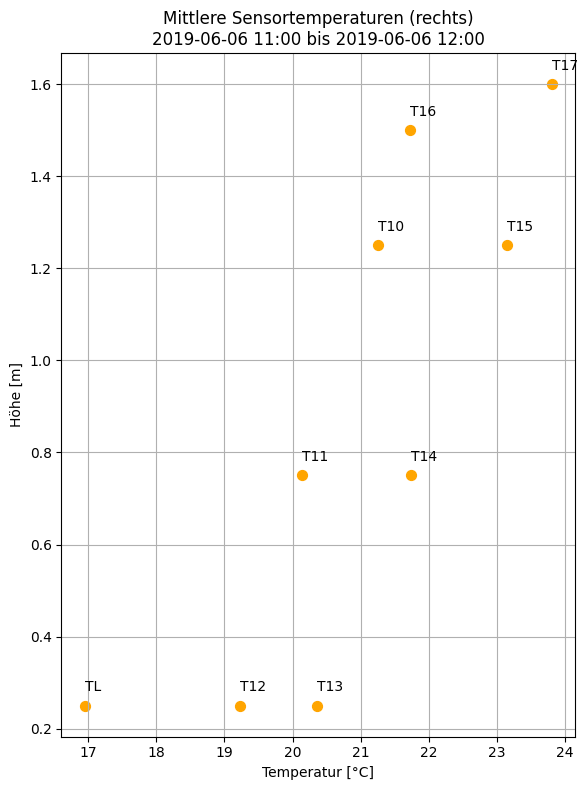

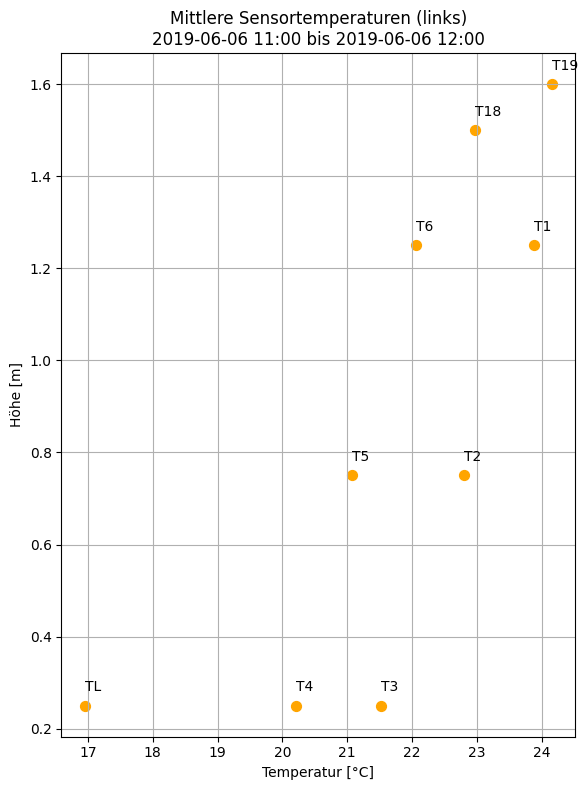

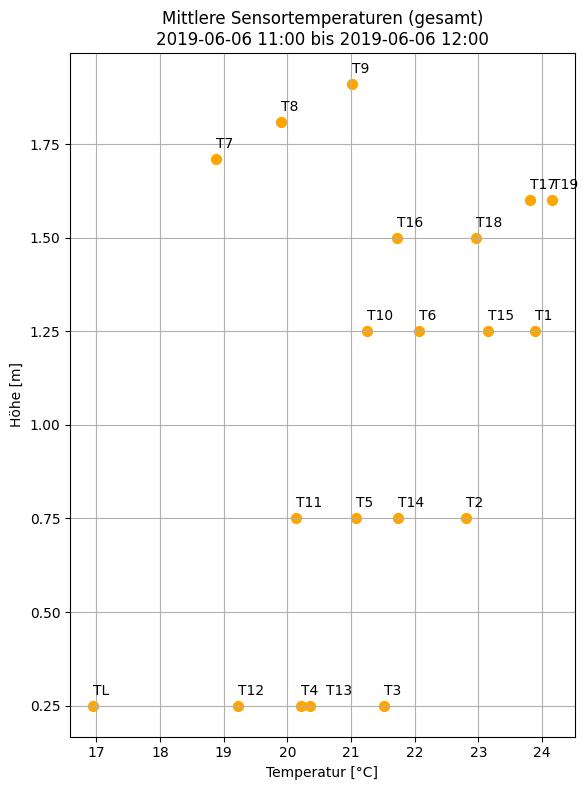

In [119]:
plot_mitteltemperaturen(
    "2019-06-06 11:00",
    "2019-06-06 12:00",
    "rechts"
)
plot_mitteltemperaturen(
    "2019-06-06 11:00",
    "2019-06-06 12:00",
    "links"
)
plot_mitteltemperaturen(
    "2019-06-06 11:00",
    "2019-06-06 12:00",
    "gesamt"
)


In [148]:
def plot_temperatur_heatmap(start, ende, modus, querschnitt, title=None):
    """
    Plottet zwei Heatmaps der Sensortemperaturen über Zeit:
    1) Skizzenreihenfolge
    2) Sortiert nach Sensorhöhe (unten → oben)
    """
    import matplotlib.dates as mdates
    import matplotlib.colors as mcolors
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Sensorlisten für die Querschnitte
    sensoren_links_skizze = ["TL", "T1", "T2", "T3", "T4", "T5", "T6", "T18", "T19"]
    sensoren_rechts_skizze = ["TL", "T10", "T11", "T12", "T13", "T14", "T15", "T16", "T17"]
    
    # Auswahl der Sensoren
    if querschnitt == "links":
        sensoren_skizze_plot = sensoren_links_skizze
        querschnitt_name = "linker Teilquerschnitt"
    elif querschnitt == "rechts":
        sensoren_skizze_plot = sensoren_rechts_skizze
        querschnitt_name = "rechter Teilquerschnitt"
    elif querschnitt == "gesamt":
        sensoren_skizze_plot = sensoren_skizze
        querschnitt_name = "Gesamtquerschnitt"
    else:
        raise ValueError("querschnitt muss 'links', 'rechts' oder 'gesamt' sein")
    
    # Zeitraum filtern
    df_zeitraum = gesamt_df.loc[start:ende]
    
    # Sensordaten (Excel → Skizze gemappt)
    excel_spalten = [skizze_to_excel[s] for s in sensoren_skizze_plot]
    werte = df_zeitraum[excel_spalten].values
    df_skizze = pd.DataFrame(werte, index=df_zeitraum.index, columns=sensoren_skizze_plot)
    
    # Modus
    if modus == "relativ":
        df_skizze = df_skizze.sub(df_skizze["TL"], axis=0)
        cmap = mcolors.LinearSegmentedColormap.from_list(
            "relativ_spektrum",
            ["darkblue", "blue", "lightblue", "orange", "red", "darkred"]
        )
        cbar_label = "ΔT zu TL [°C]"
    elif modus == "absolut":
        cmap = mcolors.LinearSegmentedColormap.from_list(
            "absolut_spektrum",
            ["black", "darkblue", "turquoise", "green", "yellow", "red"]
        )
        cbar_label = "Temperatur [°C]"
    else:
        raise ValueError("modus muss 'absolut' oder 'relativ' sein")
    
    # --------------------------------------------------
    # PLOT 1 – Skizzenreihenfolge
    # --------------------------------------------------
    plt.figure(figsize=(14,6))
    im = plt.imshow(df_skizze.T, aspect='auto', origin='lower', cmap=cmap)
    plt.colorbar(im, label=cbar_label)
    
    y_labels = [f"{s} ({skizze_to_excel[s]})" for s in sensoren_skizze_plot]
    plt.yticks(np.arange(len(sensoren_skizze_plot)), y_labels)
    
    ax = plt.gca()
    xticks = np.linspace(0, len(df_skizze.index)-1, 10)
    ax.set_xticks(xticks)
    ax.set_xticklabels(
        [df_skizze.index[int(i)].strftime('%d.%m.%Y %H:%M') for i in xticks],
        rotation=45
    )
    
    plt.xlabel("Zeit")
    plt.ylabel("Sensor (Skizzenreihenfolge)")
    plt.title(
        title if title else
        f"Temperatur-Heatmap ({modus}, {querschnitt_name})\nSkizzenreihenfolge\n{start} bis {ende}"
    )
    plt.tight_layout()
    plt.show()
    
    # --------------------------------------------------
    # PLOT 2 – nach Höhe sortiert
    # --------------------------------------------------
    sensoren_nach_hoehe = sorted(
        sensoren_skizze_plot,
        key=lambda s: sensor_hoehen[s]
    )
    
    df_hoehe = df_skizze[sensoren_nach_hoehe]
    
    plt.figure(figsize=(14,6))
    im = plt.imshow(df_hoehe.T, aspect='auto', origin='lower', cmap=cmap)
    plt.colorbar(im, label=cbar_label)
    
    y_labels_h = [
        f"{s} ({skizze_to_excel[s]})  z={sensor_hoehen[s]:.2f} m"
        for s in sensoren_nach_hoehe
    ]
    plt.yticks(np.arange(len(sensoren_nach_hoehe)), y_labels_h)
    
    ax = plt.gca()
    ax.set_xticks(xticks)
    ax.set_xticklabels(
        [df_hoehe.index[int(i)].strftime('%d.%m.%Y %H:%M') for i in xticks],
        rotation=45
    )
    
    plt.xlabel("Zeit")
    plt.ylabel("Sensor (nach Höhe sortiert)")
    plt.title(
        title if title else
        f"Temperatur-Heatmap ({modus}, {querschnitt_name})\nNach Höhe sortiert (unten → oben)\n{start} bis {ende}"
    )
    plt.tight_layout()
    plt.show()


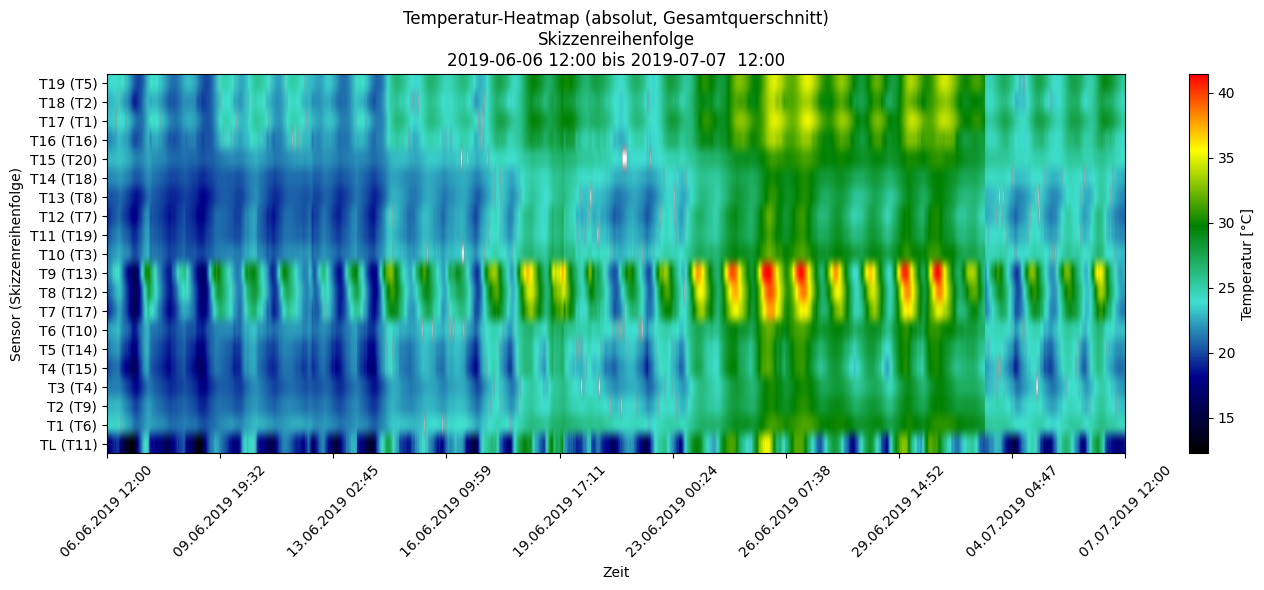

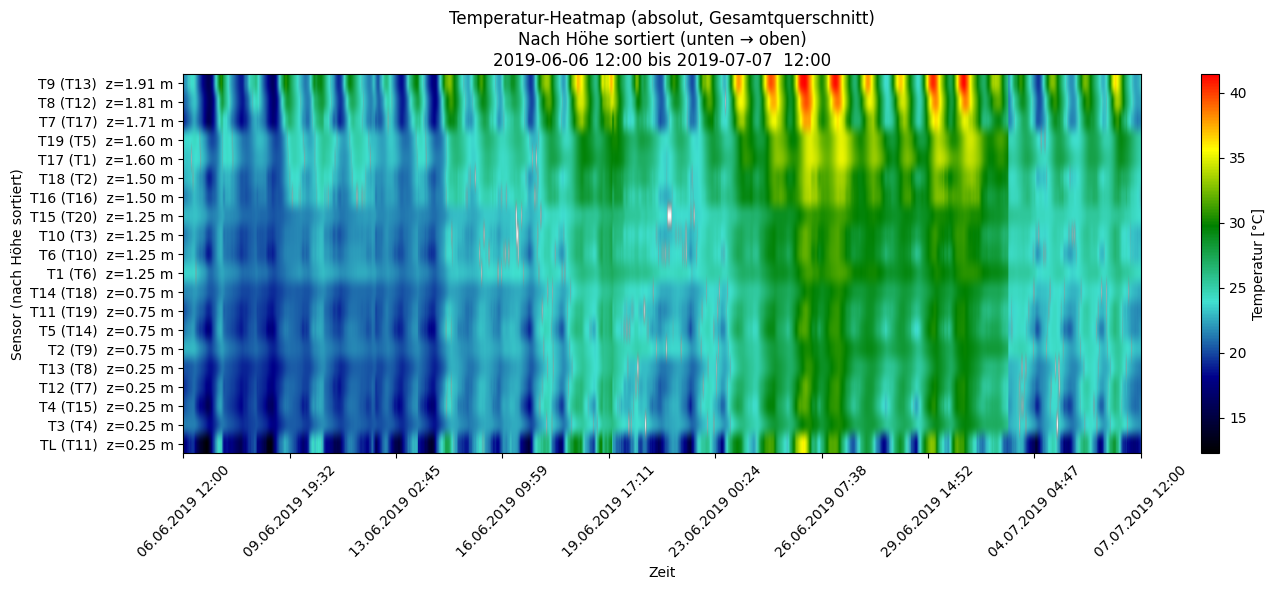

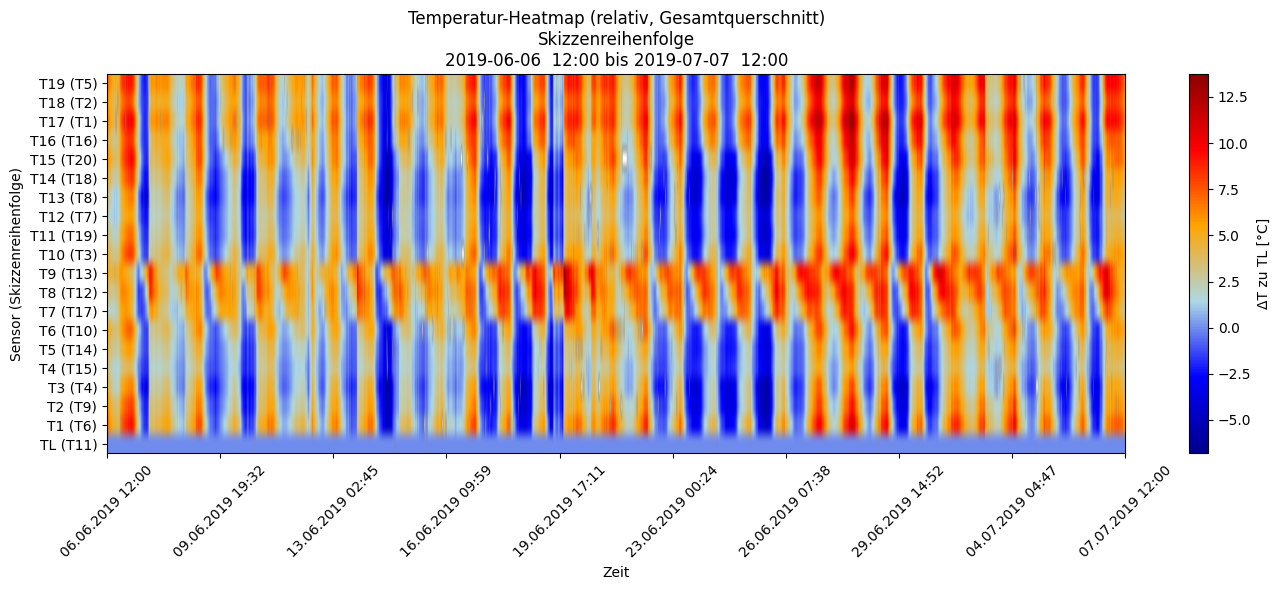

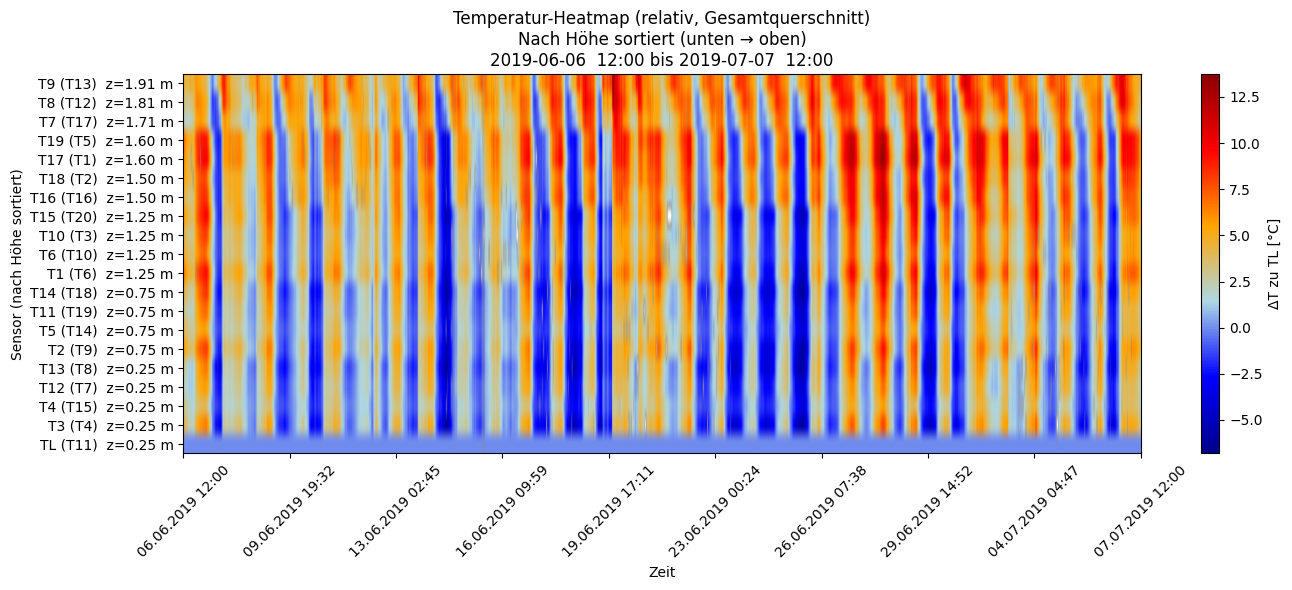

In [152]:
# Absolute Temperaturen für Gesamtquerschnitt
plot_temperatur_heatmap("2019-06-06 12:00", "2019-07-07  12:00", modus="absolut", querschnitt="gesamt")

# Relative Temperaturen für linke Seite
plot_temperatur_heatmap("2019-06-06  12:00", "2019-07-07  12:00", modus="relativ", querschnitt="gesamt")


In [166]:
def auswertung_extrema(start, ende):
    """
    Bestimmt Dreitagesextreme des vertikalen Temperaturgradienten
    und wertet sie mit der Typ-III-Extremwertverteilung (Weibull) aus.
    Bezug: Gesamtquerschnitt
    """
    from scipy.stats import weibull_min
    
    # -----------------------------
    # 1) Zeitraum filtern
    # -----------------------------
    df = gesamt_df.loc[start:ende]

    # Sensoren nach Höhe sortieren
    sensoren_sortiert = sorted(sensoren_skizze, key=lambda s: sensor_hoehen[s])
    sensor_unten = sensoren_sortiert[0]
    sensor_oben = sensoren_sortiert[-1]

    # Sensordaten holen
    T_unten = df[skizze_to_excel[sensor_unten]]
    T_oben = df[skizze_to_excel[sensor_oben]]

    # Vertikaler Temperaturanteil (Gradient)
    delta_T = T_oben - T_unten
    delta_T.name = "ΔT_vertikal"

    # -----------------------------
    # 2) Dreitagesextreme
    # -----------------------------
    maxima_3d = delta_T.resample("3D").max().dropna()
    minima_3d = delta_T.resample("3D").min().dropna()

    # Für Weibull der Größtwerte → Betrag der Minima
    minima_3d_abs = np.abs(minima_3d)

    # -----------------------------
    # 3) Weibull-Anpassung
    # -----------------------------
    # Maxima
    c_max, loc_max, scale_max = weibull_min.fit(maxima_3d, floc=0)

    # Minima (Beträge)
    c_min, loc_min, scale_min = weibull_min.fit(minima_3d_abs, floc=0)

    # Quantile
    T_k = 0.98   # charakteristisch
    T_d = 0.998  # Bemessung

    Tk_max = weibull_min.ppf(T_k, c_max, loc=loc_max, scale=scale_max)
    Td_max = weibull_min.ppf(T_d, c_max, loc=loc_max, scale=scale_max)

    Tk_min = weibull_min.ppf(T_k, c_min, loc=loc_min, scale=scale_min)
    Td_min = weibull_min.ppf(T_d, c_min, loc=loc_min, scale=scale_min)

    gamma_max = Td_max / Tk_max
    gamma_min = Td_min / Tk_min

    # -----------------------------
    # 4) Visualisierung
    # -----------------------------
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Zeitreihe Maxima
    axs[0,0].plot(maxima_3d.index, maxima_3d, marker="o")
    axs[0,0].set_title("3-Tages-Maxima ΔT")
    axs[0,0].set_ylabel("ΔT [°C]")
    axs[0,0].grid(True)

    # Zeitreihe Minima
    axs[0,1].plot(minima_3d.index, minima_3d, marker="o", color="blue")
    axs[0,1].set_title("3-Tages-Minima ΔT")
    axs[0,1].set_ylabel("ΔT [°C]")
    axs[0,1].grid(True)

    # Weibull Maxima
    x = np.linspace(0, maxima_3d.max()*1.1, 200)
    axs[1,0].plot(x, weibull_min.cdf(x, c_max, scale=scale_max))
    axs[1,0].axvline(Tk_max, color="green", label="T_k")
    axs[1,0].axvline(Td_max, color="red", label="T_d")
    axs[1,0].set_title("Weibull-Verteilung – Maxima")
    axs[1,0].legend()
    axs[1,0].grid(True)

    # Weibull Minima
    x = np.linspace(0, minima_3d_abs.max()*1.1, 200)
    axs[1,1].plot(x, weibull_min.cdf(x, c_min, scale=scale_min))
    axs[1,1].axvline(Tk_min, color="green", label="T_k")
    axs[1,1].axvline(Td_min, color="red", label="T_d")
    axs[1,1].set_title("Weibull-Verteilung – |Minima|")
    axs[1,1].legend()
    axs[1,1].grid(True)

    plt.suptitle("Dreitagesextreme des vertikalen Temperaturanteils\nGesamtquerschnitt")
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # 5) Ergebnisse ausgeben
    # -----------------------------
    print("MAXIMA:")
    print(f"T_k = {Tk_max:.2f} °C")
    print(f"T_d = {Td_max:.2f} °C")
    print(f"γ   = {gamma_max:.2f}\n")

    print("MINIMA (Beträge):")
    print(f"T_k = {Tk_min:.2f} °C")
    print(f"T_d = {Td_min:.2f} °C")
    print(f"γ   = {gamma_min:.2f}")


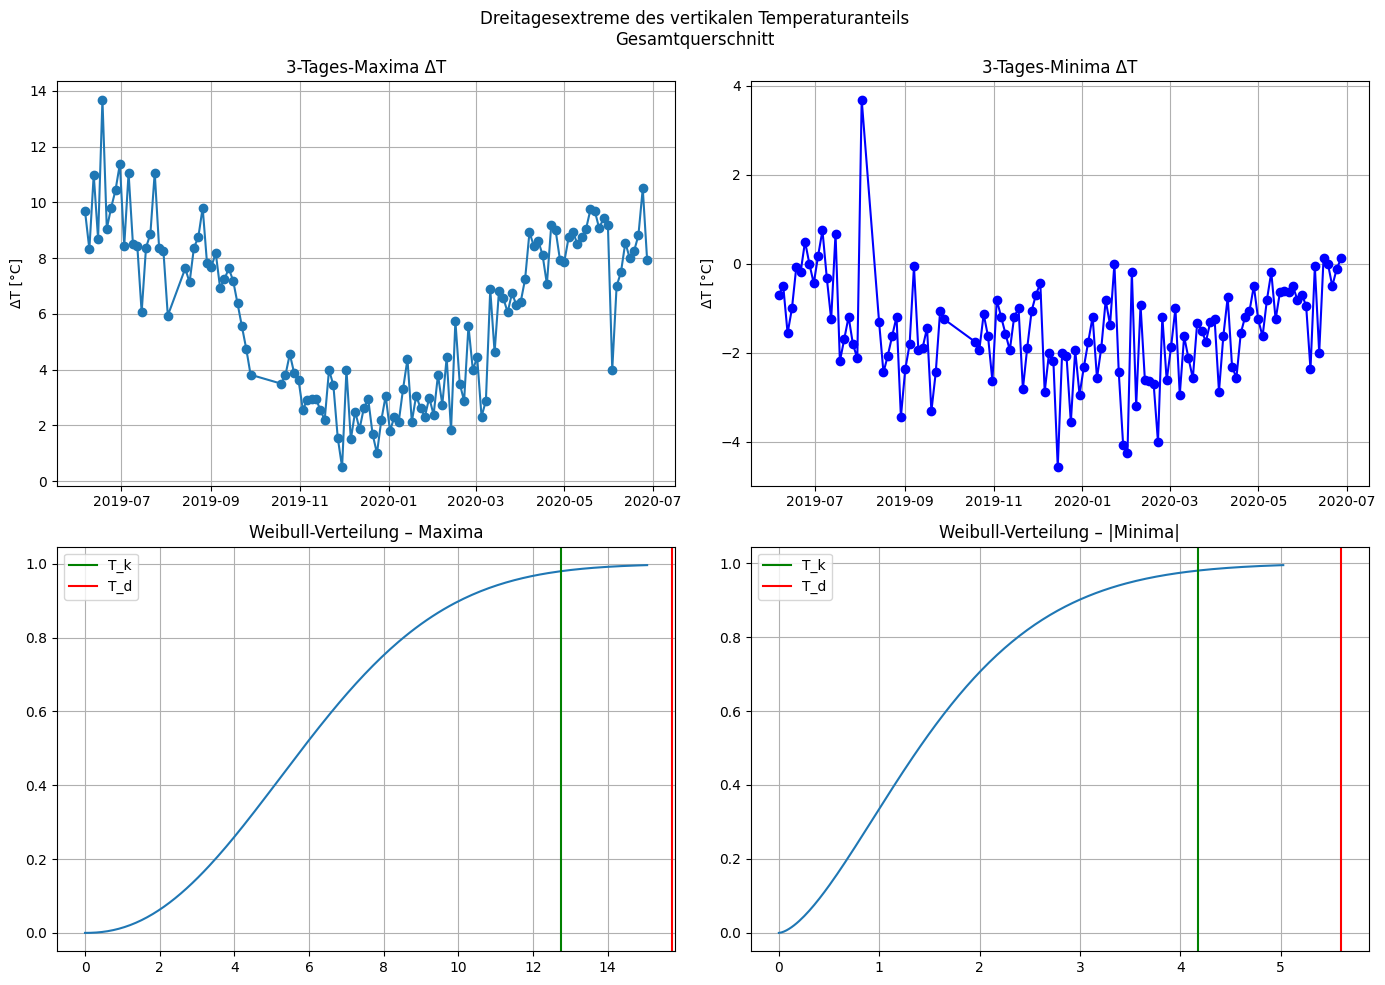

MAXIMA:
T_k = 12.75 °C
T_d = 15.71 °C
γ   = 1.23

MINIMA (Beträge):
T_k = 4.18 °C
T_d = 5.60 °C
γ   = 1.34


In [167]:

auswertung_extrema("2019-06-06", "2020-06-28  12:00")

MAXIMA:
T_k = 13.90 °C
T_d = 17.81 °C
γ   = 1.28
k   = 2.30

MINIMA (Beträge):
T_k = 3.30 °C
T_d = 4.48 °C
γ   = 1.36
k   = 1.85


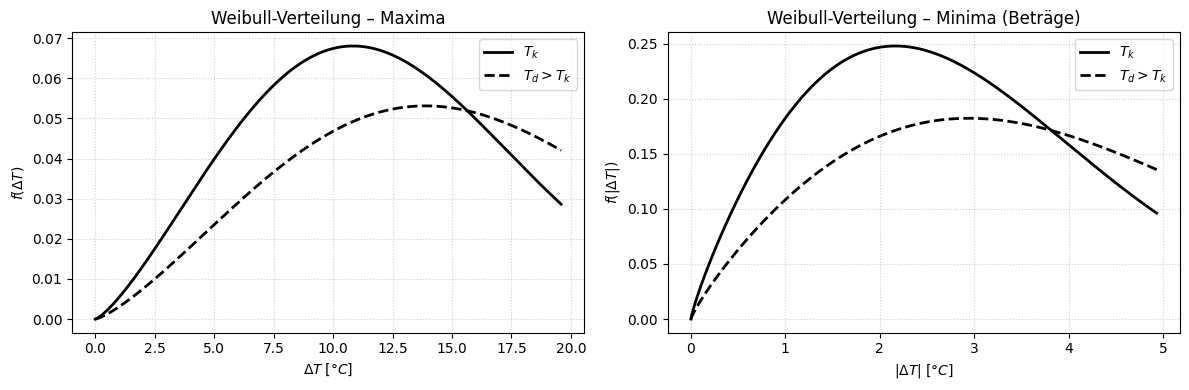

In [165]:
# Zelle: Dreitagesextreme + Weibull-Verteilung (Gesamtquerschnitt)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

# -----------------------------
# 1. Zeitraum festlegen
# -----------------------------
start = "2019-07-01"
ende  = "2020-07-01"

df = gesamt_df.loc[start:ende]

# -----------------------------
# 2. Vertikaler Temperaturanteil ΔT
#    (Gesamtquerschnitt, alle Sensoren außer TL)
# -----------------------------
sensoren_ohne_TL = [s for s in sensoren_skizze if s != "TL"]
excel_spalten = [skizze_to_excel[s] for s in sensoren_ohne_TL]

deltaT = df[excel_spalten].max(axis=1) - df[excel_spalten].min(axis=1)

# -----------------------------
# 3. 3-Tages-Extreme
# -----------------------------
deltaT_3d_max = deltaT.resample("3D").max().dropna()
deltaT_3d_min = deltaT.resample("3D").min().dropna()

daten_max = deltaT_3d_max.values
daten_min = np.abs(deltaT_3d_min.values)  # Beträge

# -----------------------------
# 4. Weibull-Fit (Typ III)
# -----------------------------
k_max, loc_max, lam_max = weibull_min.fit(daten_max, floc=0)
k_min, loc_min, lam_min = weibull_min.fit(daten_min, floc=0)

# Sicherheitsniveaus
p_k = 0.98
p_d = 0.999

T_k_max = weibull_min.ppf(p_k, k_max, scale=lam_max)
T_d_max = weibull_min.ppf(p_d, k_max, scale=lam_max)
gamma_max = T_d_max / T_k_max

T_k_min = weibull_min.ppf(p_k, k_min, scale=lam_min)
T_d_min = weibull_min.ppf(p_d, k_min, scale=lam_min)
gamma_min = T_d_min / T_k_min

# -----------------------------
# 5. Ergebnisse ausgeben
# -----------------------------
print("MAXIMA:")
print(f"T_k = {T_k_max:.2f} °C")
print(f"T_d = {T_d_max:.2f} °C")
print(f"γ   = {gamma_max:.2f}")
print(f"k   = {k_max:.2f}\n")

print("MINIMA (Beträge):")
print(f"T_k = {T_k_min:.2f} °C")
print(f"T_d = {T_d_min:.2f} °C")
print(f"γ   = {gamma_min:.2f}")
print(f"k   = {k_min:.2f}")

# -----------------------------
# 6. Weibull-Dichtefunktion
# -----------------------------
def weibull_pdf(x, k, lam):
    return (k / lam) * (x / lam)**(k - 1) * np.exp(-(x / lam)**k)

x_max = np.linspace(0, T_d_max * 1.1, 500)
x_min = np.linspace(0, T_d_min * 1.1, 500)

# -----------------------------
# 7. Plot wie Referenzgrafik
# -----------------------------
fig, axs = plt.subplots(1, 2, figsize=(12,4))

# Maxima
axs[0].plot(x_max, weibull_pdf(x_max, k_max, T_k_max),
            color="black", linewidth=2, label=r"$T_k$")
axs[0].plot(x_max, weibull_pdf(x_max, k_max, T_d_max),
            color="black", linestyle="--", linewidth=2, label=r"$T_d > T_k$")

axs[0].set_title("Weibull-Verteilung – Maxima")
axs[0].set_xlabel(r"$\Delta T\;[\degree C]$")
axs[0].set_ylabel(r"$f(\Delta T)$")
axs[0].grid(True, linestyle=":", alpha=0.6)
axs[0].legend()

# Minima
axs[1].plot(x_min, weibull_pdf(x_min, k_min, T_k_min),
            color="black", linewidth=2, label=r"$T_k$")
axs[1].plot(x_min, weibull_pdf(x_min, k_min, T_d_min),
            color="black", linestyle="--", linewidth=2, label=r"$T_d > T_k$")

axs[1].set_title("Weibull-Verteilung – Minima (Beträge)")
axs[1].set_xlabel(r"$|\Delta T|\;[\degree C]$")
axs[1].set_ylabel(r"$f(|\Delta T|)$")
axs[1].grid(True, linestyle=":", alpha=0.6)
axs[1].legend()

plt.tight_layout()
plt.show()
